In [3]:
 import pandas as pd
 import tensorflow as tf
 from tensorflow import keras
 import numpy as np

In [4]:
df = pd.read_csv("/content/drive/MyDrive/train.csv")

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
# Preprocess

from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y  = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 200000  # number of words in vocab

In [9]:
vectorizer = TextVectorization(max_tokens= MAX_FEATURES,   #max words
                               output_sequence_length=1800, #max sentence length
                               output_mode='int')

In [10]:
vectorizer.adapt(X.values)  #learn from X values

In [11]:
 vectorizer('Hello world, life is great')[:5]  #learned

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([288, 263, 306,   9, 275])>

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))  #(input_feature,target_variable)
dataset = dataset.cache()   # caches data
dataset = dataset.shuffle(160000)  # how large buffer size need to be
dataset = dataset.batch(16) # batches..each batch represent series of 16 samples
dataset = dataset.prefetch(8)  # helps bottlenecks

In [15]:
batch_X,batch_y = dataset.as_numpy_iterator().next()  # gives one batch

In [16]:
train = dataset.take(int(len(dataset)*.7))  # take to take the partition and assign the variable
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))  # we skip the 70% then take 30%
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [17]:
train_generator = train.as_numpy_iterator()

In [18]:
train_generator.next()  # grab the next batch

(array([[     8,    105,      7, ...,      0,      0,      0],
        [    14,    293,    398, ...,      0,      0,      0],
        [    46,     33,     15, ...,      0,      0,      0],
        ...,
        [   171, 144879,      5, ...,      0,      0,      0],
        [   583,      8,    119, ...,      0,      0,      0],
        [ 57697,     28,    652, ...,      0,      0,      0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [20]:
model = keras.Sequential([
    # create the embedding layer
    keras.layers.Embedding(MAX_FEATURES+1,32),
    # bidirectional LSTM layer
    keras.layers.Bidirectional(LSTM(32, activation='tanh')),
    # feature extractor fully connected layers
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(6,activation='sigmoid')
])



In [21]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [23]:
history = model.fit(train,epochs=1,validation_data=val)

6981/6981 [==============================] - 768s 108ms/step - loss: 0.0668 - accuracy: 0.9817 - val_loss: 0.0455 - val_accuracy: 0.9938


In [24]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

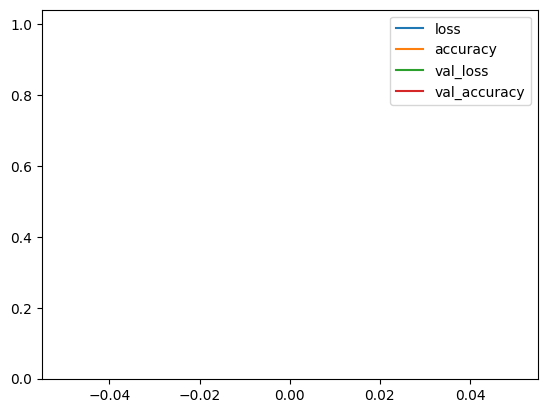

In [25]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [29]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [31]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [32]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 1s 646ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]])

In [33]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [34]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [35]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 54ms/step


In [36]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8409004211425781, Recall:0.6448215246200562, Accuracy:0.46439316868782043


In [37]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [38]:
import tensorflow as tf
import gradio as gr

In [39]:
model.save('toxicity.h5')

In [40]:
model = tf.keras.models.load_model('toxicity.h5')

In [41]:
input_str = vectorizer('hey i freaken hate you!')

In [42]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 2s 2s/step


In [43]:
res

array([[0.6590075 , 0.06595073, 0.34846354, 0.0806083 , 0.40376985,
        0.13132668]], dtype=float32)

In [44]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [45]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `numeric` parameter is deprecated, and it has no effect
  super().__init__(


In [46]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3a072031291a30d0cd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
